In [1]:
# Major version: the feature setup
# Minor version: model hypertunning
VERSION = 'v2.0'
major_VERSION = VERSION.split('.')[0]+'.0'

# Model Details
## Features:
- One hot encoded **day of week** and **month** (not year)
- Weather feature (OHE):
    - Icons (cloudy, partial cloudy, ...)
    - Precipitates Type (None, Snow, Sleet, Rain)
- Station info:
    - community area (OHE)
    - capacity
    - long, lat
    
## Target
- Log scale/normal scale
    
# Work Flow
## Training Preprocessing
- Merge station community area (Join tables)
- Drop id after merging
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Pipeline
- OHE on date time (Remember column indices)
- Scaling for `year, lon_ave, lat_ave, dp_max, temp_high, temp_low` (`MinMaxScaler`)
- Regressor()

## Test Preprocessing
- Start with Pandas template (station_id, lon_ave, lat_ave, dp_max, OHE community area)
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Post prediction
- Rescale if trained on log
- Hard cap negative (activation function)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm_notebook as tqdm

## Load data

In [5]:
INFO_verbose = False

In [6]:
%%time
st_template = pd.read_pickle('../data/model_v1.0_template.pk')

CPU times: user 4.3 ms, sys: 3.07 ms, total: 7.37 ms
Wall time: 7.56 ms


In [7]:
if INFO_verbose:
    st_template.info()

In [8]:
%%time
## load preprocessed data

if os.path.exists('../data/divvy_data_model_'+major_VERSION+'.pk'):
    print("Loading from previous pickle file.")
    data = pd.read_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
else:
    print("Create data set for this model... ")
    data_lst = []

    for year in [2013, 2014, 2015, 2016, 2017, 2018]:
        dt_tmp = pd.read_feather('../data/Final_Divvy_data_'+str(year)+'.feather')
        data_lst.append(dt_tmp)

    data = pd.concat(data_lst, ignore_index=True, sort=True) # !!! Careful with Pandas future version


    data.to_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
    print("Data saved to pickle file")

Loading from previous pickle file.
CPU times: user 209 ms, sys: 621 ms, total: 830 ms
Wall time: 1.33 s


In [9]:
if INFO_verbose:
    data.info()

## Prepare Historical Data table
- Group data by `station_id`, `month`, `year`, `total_out`
- Calculated average of previous historical data
- Add New station Flag
- Fill nan with zero

In [10]:
def _get_previous_ave(row, year):
    tmp_sum = 0
    tmp_count = 0
    for y in range(2013, year):
        if not np.isnan(row.total_out[y]):
            tmp_count += 1
            tmp_sum += row.total_out[y]
            
    if tmp_count == 0:
        return 
    
    return tmp_sum/tmp_count

def _check_if_new(row, year):
    for y in range(2013, year):
        if not np.isnan(row.total_out[y]):
            return 1
            
    return 0

In [11]:
%%time
if not os.path.exists('../data/historical_data.feather'):
    print("Get new historical data")
    historical_raw = data[['station_id', 'month', 'year', 'total_out']]\
                        .groupby(['station_id', 'month', 'year'])\
                        .mean().unstack(level=-1).reset_index().copy()

    for y in tqdm([2013, 2014, 2015, 2016, 2017, 2018, 2019]):
        historical_raw['hisave_'+str(y)] = historical_raw.apply(lambda row: _get_previous_ave(row, y), axis=1)
        historical_raw['newstation_'+str(y)] = historical_raw.apply(lambda row: _check_if_new(row, y), axis=1)
        
    history_df = pd.DataFrame()
    for y in [2013, 2014, 2015, 2016, 2017, 2018, 2019]:
        tmp = pd.DataFrame()
        tmp['station_id'] = historical_raw.station_id
        tmp['month'] = historical_raw.month
        tmp['year'] = y
        tmp['historical_ave'] = historical_raw['hisave_'+str(y)]
        tmp['newstation'] = historical_raw['newstation_'+str(y)]
        history_df = pd.concat([history_df, tmp], ignore_index=True, sort=False) 
    history_df = history_df.fillna(0)
    history_df.to_feather('../data/historical_data.feather')
else:
    print("Load data")
    history_df = pd.read_feather('../data/historical_data.feather')

Load data
CPU times: user 36.7 ms, sys: 58.6 ms, total: 95.3 ms
Wall time: 373 ms


In [12]:
future_tmplt = history_df[history_df.year == 2019][['station_id', 'month', 'historical_ave', 'newstation']]\
    .sort_values(by='month').reset_index()
future_tmplt.to_pickle('../data/future_hist.pk')

In [13]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50022 entries, 0 to 50021
Data columns (total 5 columns):
station_id        50022 non-null int64
month             50022 non-null int64
year              50022 non-null int64
historical_ave    50022 non-null float64
newstation        50022 non-null int64
dtypes: float64(1), int64(4)
memory usage: 1.9 MB


In [14]:
%%time
data = pd.merge(data, history_df, on=['year', 'month', 'station_id'], how='left')

CPU times: user 1.33 s, sys: 844 ms, total: 2.17 s
Wall time: 1.62 s


In [15]:
if INFO_verbose:
    data.info()

## Get target value

In [16]:
target_in = data.total_in 
target_out = data.total_out
target_diff = data.total_out - data.historical_ave

## Prepare features

In [17]:
# Prescreening for useful features
feats = pd.merge(data[['station_id', 'month', 'dayofweek', 'year',
                       'icon_clear-day', 'icon_cloudy', 'icon_fog', 
                       'icon_partly-cloudy-day', 'icon_rain', 
                       'icon_sleet', 'icon_snow',
                       'temperatureHigh', 'temperatureLow',
                       'historical_ave', 'newstation',
                         ]], st_template, 
                    left_on='station_id', right_on='id').drop(['station_id', 'id'], axis=1)

In [18]:
feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 64 columns):
month                                    947515 non-null int64
dayofweek                                947515 non-null int64
year                                     947515 non-null float64
icon_clear-day                           947515 non-null int64
icon_cloudy                              947515 non-null int64
icon_fog                                 380828 non-null float64
icon_partly-cloudy-day                   947515 non-null int64
icon_rain                                947515 non-null int64
icon_sleet                               566687 non-null float64
icon_snow                                735051 non-null float64
temperatureHigh                          947515 non-null float64
temperatureLow                           947515 non-null float64
historical_ave                           947515 non-null float64
newstation                               947515 non-null

## Reordering dataframe

In [19]:
# Reordering
cols = []
cols.extend(feats.columns[17:])
cols.extend(feats.columns[2:17])
cols.extend(feats.columns[:2])

In [20]:
feats_ro = feats[cols]

In [21]:
if INFO_verbose:
    feats_ro.info()

In [22]:
feats_ro = feats_ro.fillna(0)

In [23]:
feats_ro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 64 columns):
community_area_ALBANY_PARK               947515 non-null uint8
community_area_ARMOUR_SQUARE             947515 non-null uint8
community_area_AUSTIN                    947515 non-null uint8
community_area_AVALON_PARK               947515 non-null uint8
community_area_AVONDALE                  947515 non-null uint8
community_area_BRIDGEPORT                947515 non-null uint8
community_area_CHATHAM                   947515 non-null uint8
community_area_DOUGLAS                   947515 non-null uint8
community_area_EAST_GARFIELD_PARK        947515 non-null uint8
community_area_EDGEWATER                 947515 non-null uint8
community_area_ENGLEWOOD                 947515 non-null uint8
community_area_Evanston                  947515 non-null uint8
community_area_FULLER_PARK               947515 non-null uint8
community_area_GRAND_BOULEVARD           947515 non-null uint8
communi

## One hot encoding date

In [24]:
feats_fnl = pd.get_dummies(feats_ro, columns=['month', 'dayofweek'])

## Save model details into txt 

In [25]:
import io

buffer = io.StringIO()
feats_fnl.info(buf=buffer)
s = buffer.getvalue()

with open("../model_features_details/features_"+major_VERSION+'.txt', "w", encoding="utf-8") as f: 
    f.write(s)

## Convert to numpy matrix 

In [26]:
features_ = feats_fnl.to_numpy()

In [27]:
features_.shape

(947515, 81)

In [28]:
feats_fnl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 81 columns):
community_area_ALBANY_PARK               947515 non-null uint8
community_area_ARMOUR_SQUARE             947515 non-null uint8
community_area_AUSTIN                    947515 non-null uint8
community_area_AVALON_PARK               947515 non-null uint8
community_area_AVONDALE                  947515 non-null uint8
community_area_BRIDGEPORT                947515 non-null uint8
community_area_CHATHAM                   947515 non-null uint8
community_area_DOUGLAS                   947515 non-null uint8
community_area_EAST_GARFIELD_PARK        947515 non-null uint8
community_area_EDGEWATER                 947515 non-null uint8
community_area_ENGLEWOOD                 947515 non-null uint8
community_area_Evanston                  947515 non-null uint8
community_area_FULLER_PARK               947515 non-null uint8
community_area_GRAND_BOULEVARD           947515 non-null uint8
communi

## Building pipelines

In [29]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

In [30]:
sklearn.__version__

'0.21.2'

In [31]:
%%time
model = Pipeline([
    ('mms', MinMaxScaler(feature_range=(0, 1))),
    ('rf', RandomForestRegressor(n_estimators=30, min_samples_split=5))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)

CPU times: user 1.68 s, sys: 1.19 s, total: 2.87 s
Wall time: 3.55 s


In [103]:
%%time
model.fit(X_train, y_train)

CPU times: user 7min 52s, sys: 6.33 s, total: 7min 59s
Wall time: 8min 20s


Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=30, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [104]:
model.score(X_test, y_test)

0.7098489214072566

In [107]:
# Save model, features and targets
Model_name = 'random_forest_more_tree_'

with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'wb') as p:
    pickle.dump(model, p)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'wb') as ptf:
    pickle.dump(X_test, ptf)

with open('../model_data/'+Model_name+'testtarget_'+VERSION+'.pk', 'wb') as ptg:
    pickle.dump(y_test, ptg)

In [155]:
# First check
y_pred = model.predict(X_test)

In [153]:
y_base = feats_ro.iloc[y_test.index]['historical_ave']

In [145]:
X_test.shape

(189503, 81)

In [154]:
print("R2 score:")
print("Model:", r2_score(y_test, y_pred))
print("Baseline:", r2_score(y_test, y_base))
print()
print("MAE:")
print("Model:", mean_absolute_error(y_test, y_pred))
print("Baseline:", mean_absolute_error(y_test, y_base))
print()
print("RMSE:")
print("Model:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Baseline:", np.sqrt(mean_squared_error(y_test, y_base)))

R2 score:
Model: 0.7098489214072565
Baseline: -0.43536036315876503

MAE:
Model: 7.2101217885769735
Baseline: 21.08527418170661

RMSE:
Model: 18.82191959022315
Baseline: 41.86318758064847


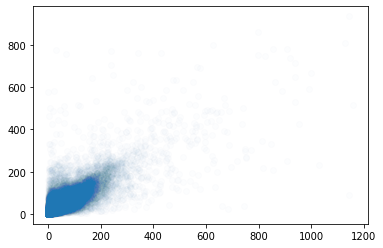

In [156]:
plt.plot(y_test, y_pred, 'o', alpha=0.01)
# plt.plot(y_test, y_base, 'or', alpha=0.01)

(0, 300)

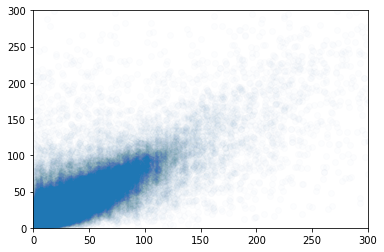

In [157]:
# Deeper Look
plt.plot(y_test, y_pred, 'o', alpha=0.01)
plt.xlim(0, 300)
plt.ylim(0, 300)

## Grid Search 

In [148]:
# %%time
# # Train Test split
# X_train, X_test, y_train, y_test = train_test_split(
#     features_, 
#     target_out, 
#     test_size=0.2, 
#     random_state=42)
# print("Train/Test splitted...")

# model_gs = GridSearchCV(
#     model,
#     {'rf__n_estimators': [20, 50], 'rf__max_depth':[5, 10, 20]},
#     cv=5,
#     n_jobs=4
# )


# model_gs.fit(X_train, y_train)
# print("Best params: ", model_gs.best_params_)

# y_pred = model_gs.predict(X_test)
# plt.plot(y_test, y_pred, 'o', alpha=0.1)

# # Save model, features and targets
# Model_name = 'random_forest_'

# with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'wb') as p:
#     pickle.dump(model_gs, p)

# with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'wb') as ptf:
#     pickle.dump(X_test, ptf)

# with open('../model_data/'+Model_name+'testtraget_'+VERSION+'.pk', 'wb') as ptg:
#     pickle.dump(y_test, ptg)

## Reload model

In [4]:
%%time
# Load previous data
# Model_name = 'random_forest_more_tree_'
Model_name = 'random_forest_'
with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'rb') as pp:
    loaded_model = pickle.load(pp)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'rb') as ptfl:
    loaded_test_feature = pickle.load(ptfl)

with open('../model_data/'+Model_name+'testtarget_'+VERSION+'.pk', 'rb') as ptgl:
    loaded_test_target = pickle.load(ptgl)

CPU times: user 660 ms, sys: 757 ms, total: 1.42 s
Wall time: 2.13 s


In [5]:
loaded_model

Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [6]:
loaded_model.score(loaded_test_feature, loaded_test_target)

0.6981120957324138

In [7]:
loaded_test_feature.shape

(189503, 81)

In [8]:
y_pred = loaded_model.predict(loaded_test_feature)

In [9]:
y_base = loaded_test_feature[:,-24]

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

In [11]:
mean_absolute_error(y_base, loaded_test_target)

21.08527418170661

In [12]:
mean_absolute_error(y_pred, loaded_test_target)

7.387740388806399

In [13]:
y_pred.shape

(189503,)

In [14]:
sum(abs(y_base - loaded_test_target) > 10)/189503

0.48831944613014044

In [15]:
sum(abs(y_pred - loaded_test_target) > 10)/189503

0.19798103460103533

Text(0.5, 1.0, 'equal, looks like circle')

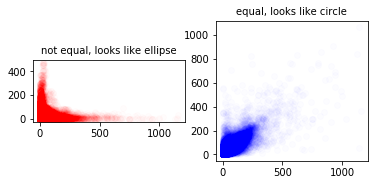

In [25]:
# Deeper Look
fig, axs = plt.subplots(1, 2)
axs[0].plot(loaded_test_target, y_base, 'or', alpha=0.01)
axs[0].set_title('not equal, looks like ellipse', fontsize=10)
axs[0].axis('equal')
axs[0].set_aspect('equal', 'box')
axs[1].plot(loaded_test_target, y_pred, 'ob', alpha=0.01)
axs[1].axis('equal')
axs[1].set_aspect('equal', 'box')
axs[1].set_title('equal, looks like circle', fontsize=10)
# plt.plot(loaded_test_target, y_pred, 'ob', alpha=0.01)
# plt.plot(loaded_test_target, y_base, 'or', alpha=0.01)
# plt.xlim(0, 300)
# plt.ylim(0, 300)

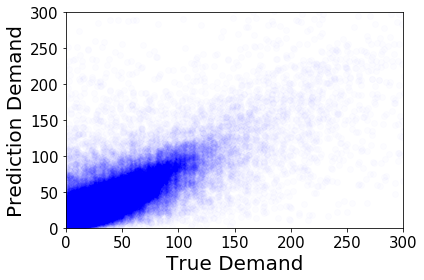

In [39]:
# Deeper Look
plt.plot(loaded_test_target, y_pred, 'ob', alpha=0.01)
plt.xlabel('True Demand', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Prediction Demand', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.tight_layout()
plt.savefig('prediction.png', dpi=200)

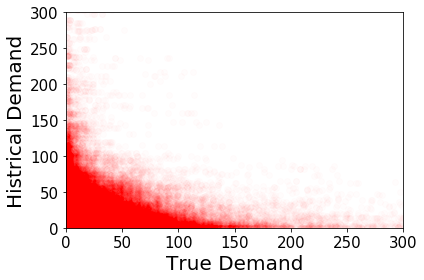

In [40]:
# Deeper Look
plt.plot(loaded_test_target, y_base, 'or', alpha=0.01)
plt.xlabel('True Demand', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Histrical Demand', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.tight_layout()
plt.savefig('history.png', dpi=200)

## Full model training

In [35]:
%%time
model = Pipeline([
    ('mms', MinMaxScaler(feature_range=(0, 1))),
    ('rf', RandomForestRegressor(n_estimators=10, min_samples_split=))
])
model.fit(features_, target_out,)

CPU times: user 1min 15s, sys: 1.19 s, total: 1min 17s
Wall time: 1min 16s


Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [36]:
# Save model, features and targets
Model_name = 'random_forest_full_'

with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'wb') as p:
    pickle.dump(model, p)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'wb') as ptf:
    pickle.dump(X_test, ptf)

with open('../model_data/'+Model_name+'testtarget_'+VERSION+'.pk', 'wb') as ptg:
    pickle.dump(y_test, ptg)